In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Add project root and scripts directories to path
project_root = os.path.abspath("..")
scripts_dir = os.path.join(project_root, "scripts")

sys.path.append(scripts_dir)

In [2]:
from dotenv import load_dotenv

load_dotenv()

INPUT_BUCKET = os.environ["SM_INPUT_BUCKET"]
TRAIN_SM_ROLE_ARN = os.environ["SM_TRAIN_ROLE_ARN"]

In [23]:
import logging
import time
import pandas as pd
from dataclasses import dataclass
from typing import Optional
import matplotlib.pyplot as plt

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

logger = logging.getLogger("forecast_project")
logger.setLevel(logging.DEBUG)

# Retail Demand Forecasting (PoC)

## Introduction
The purpose of the notebook is to provide a _proof-of-concept_ code solving item demand for retail stores. It demonstrates the integration of AWS tooling (SageMaker AutoML Jobs) and evaluates the performance with the [FEV framework](https://pypi.org/project/fev/).

The general workflow can be described as:

```
raw data -> preprocessing -> train/test split (evaluation window) -> algorithm -> performance assessment
```

## Data Preparation

(explain covariates)

### Load Raw Data
Let's begin by reading the raw dataset, and observing it's structure

In [4]:
raw_df = pd.read_csv("../data/raw/train.csv")
raw_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Basic exploratory analysis of the dataset

In [5]:
from eda import eda

eda(raw_df)

Dataset Shape: 913,000 rows, 4 columns
Memory Usage: 72.27 MB

Data Types:
date     object
store     int64
item      int64
sales     int64

No missing values in any column

Uniqueness:
date: 1,826 unique values
store: 10 unique values
item: 50 unique values
sales: 213 unique values

Summary Statistics:
               store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

Skewness & Kurtosis:
  Skewness: 0=symmetric, positive=right-skewed, negative=left-skewed
  Kurtosis: near 0=normal tails, >0=heavy tails, <0=light tails
store: Skewness 0.000, Kurtosis -1.224
item: Skewness 0.000, Kurtosis -1.201
sales

### NULLs and zeros
(TODO)

### Data Cleaning and Transformation
Because a prediction is made for a combination of (store, item) we need to create a composite `series_id` column that will act as a time series identifier.

The following transformations are applied
1. Add a derived `series_id` column (pair of `store` and `item`)
2. Cast `date` to date type

In [6]:
def create_series_id(df, store_col="store", item_col="item", sep="_"):
    df_transformed = df.copy()
    df_transformed["series_id"] = (
        df_transformed[store_col].astype(str)
        + sep
        + df_transformed[item_col].astype(str)
    ).astype(str)
    df_transformed.drop(columns=[store_col, item_col], inplace=True)
    return df_transformed


df = create_series_id(raw_df)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df.head()

,date,sales,series_id
0,2013-01-01,13,1_1
1,2013-01-02,11,1_1
2,2013-01-03,14,1_1
3,2013-01-04,13,1_1
4,2013-01-05,10,1_1


In [7]:
# find duplicates
df.value_counts(["date", "series_id"]).reset_index(name="count").query("count > 1")

,date,series_id,count


### Train/test split
In time series forecasting, a train-test split divides historical data chronologically into two parts: an earlier 'training' set used to build the model and a later 'test' set for evaluating its performance (**data not seen during training**).

This temporal division is essential because time series data is ordered by time and has dependencies across periods, unlike random splits used in other data types. Random mixing could inappropriately leak future information into model training, leading to overly optimistic results that don't reflect real-world predictive accuracy.

The key importance is preventing assessment bias and ensuring evaluations realistically simulate forecasting future unknown values from past observed data. The primary goal is to measure how well the model generalizes to unseen future periods, enabling reliable comparisons between models and guiding improvements before deployment.

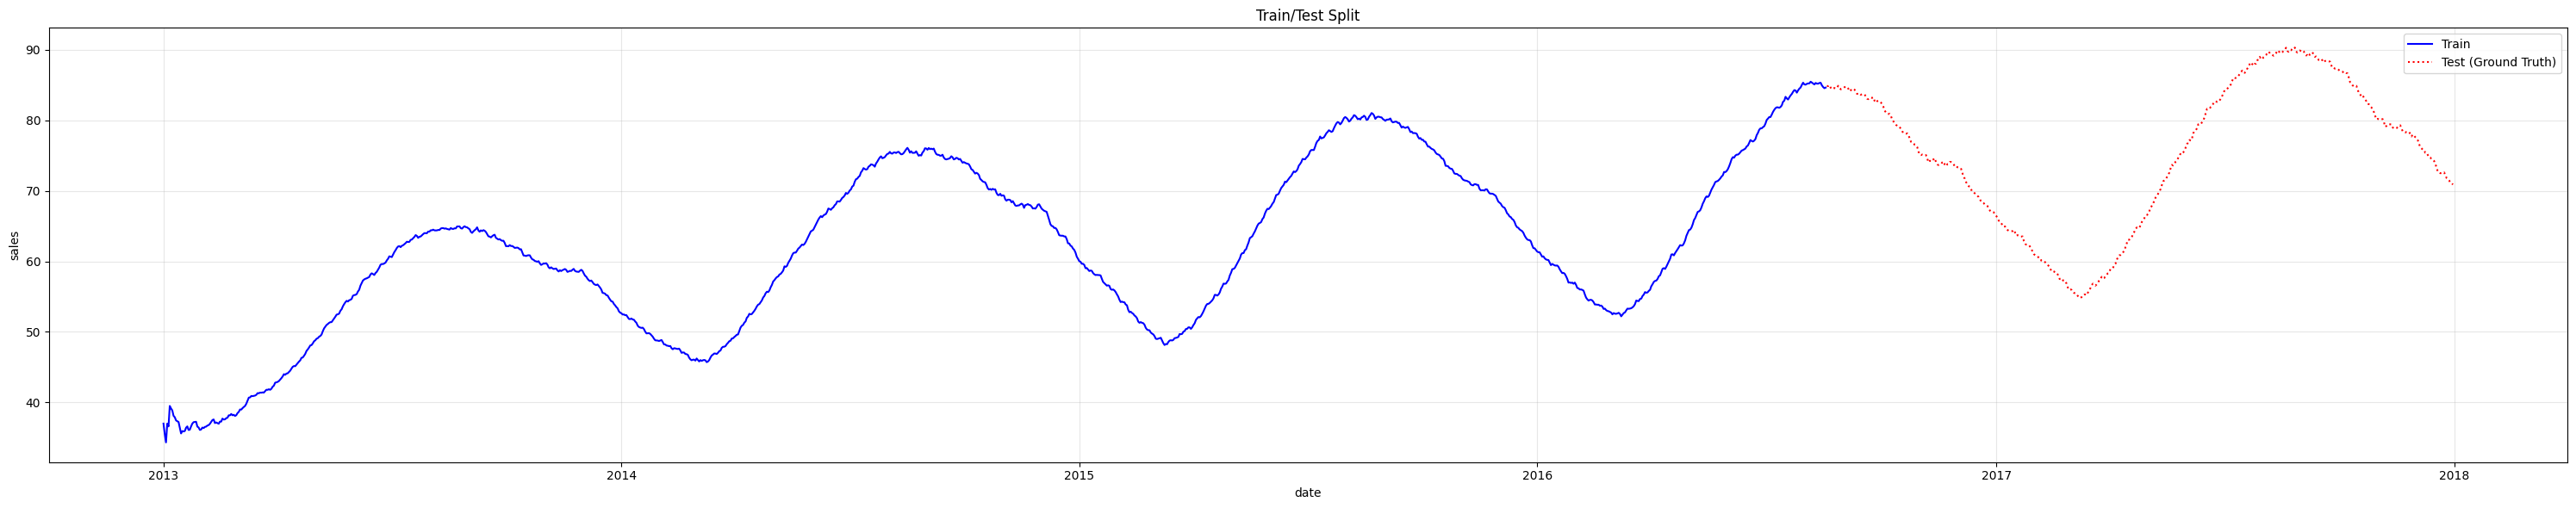

In [ ]:
from plot_series_train_test_split import plot_series_train_test_split

fig, ax = plt.subplots(figsize=(30, 6))
plot_series_train_test_split(
    df, series_id="1_10", horizon=500, smooth_window=100, fig=fig, ax=ax
)
plt.show()

In the plot above, we are trying to predict the red line (test data), given the blue line (train data).

## Model ZOO

In [9]:
# configure cache memory to optimize model re-runs

from joblib import Memory

memory = Memory("joblib_cache", verbose=0)


@dataclass
class ForecastResult:
    train_df: pd.DataFrame
    predictions_df: pd.DataFrame
    train_time: float
    predict_time: float
    model_name: Optional[str]
    best_candidate: Optional[dict]
    list_candidates: Optional[list[dict]]

### Seasonal Naïve (Baseline)
The seasonal naïve predictor is a simple forecasting method that assumes future values will repeat the same pattern as the most recent season.

For example, if sales on Mondays have been similar from week to week, the predictor will forecast next Monday’s sales to be the same as last Monday’s.

It’s often used as a baseline, because it captures repeating patterns (like day-of-week effects) without using any complex modeling.

### AWS Sagemaker AutoMLV2
SageMaker AutoMLV2 is part of the SageMaker Autopilot suite, which automates the end-to-end machine learning workflow from data preparation to model deployment ([link](https://aws.amazon.com/blogs/machine-learning/time-series-forecasting-with-amazon-sagemaker-automl/)).

It works for various types of ML problems, including time series forecasting. The user responsibility is to deliver the training dataset and properly configure the job.

SageMaker Autopilot automatically trains a set of built-in time-series forecasting algorithms and uses a stacking ensemble to produce the final model. By default, Autopilot trains the following six algorithms on your series and then ensembles them to optimize the forecast metric:

1. Convolutional Neural Network – Quantile Regression (CNN-QR)
2. DeepAR+
3. Prophet
4. Non-Parametric Time Series (NPTS)
5. Autoregressive Integrated Moving Average (ARIMA)
6. Exponential Smoothing (ETS) 

In [10]:
@memory.cache(ignore=["train_df"])
def sagemaker_automl_forecast(
    job_name: str,
    train_df: pd.DataFrame,
    horizon: int,
    timestamp_column: str,
    id_column: str,
) -> ForecastResult:
    from train_sagemaker import SageMakerTimeSeriesAutopilot
    import s3fs

    # configuration
    logger = logging.getLogger("sagemaker_automl_forecast")
    s3_uri_train_data = f"s3://{INPUT_BUCKET}/jobs/{job_name}/train.csv"
    s3_uri_inference_data = f"s3://{INPUT_BUCKET}/jobs/{job_name}/inference.csv"

    # upload training data to S3
    logger.info("Uploading train and inference data to S3")
    train_df.to_csv(s3_uri_train_data, index=False)
    train_df.to_csv(s3_uri_inference_data, index=False)

    # create cached SageMaker Autopilot helper
    sm_autopilot = SageMakerTimeSeriesAutopilot(
        job_name=job_name,
        train_data_s3_uri=s3_uri_train_data,
        role_arn=TRAIN_SM_ROLE_ARN,
    )

    # train model (est 40 min)
    train_start = time.time()
    sm_autopilot.train(
        model_output_s3_uri=f"s3://{INPUT_BUCKET}/jobs/{job_name}/models",
        forecast_horizon=horizon,
        timestamp_col=timestamp_column,
        series_identifier_col=id_column,
        target_col="sales",
        max_runtime_per_training_job_s=600,
        max_total_job_runtime_s=3600,
    )
    train_duration = time.time() - train_start

    # register best candidate estimator in sagemaker
    model = sm_autopilot.register_best_candidate()

    # make predictions
    predict_start = time.time()
    s3_uri_output = f"s3://{INPUT_BUCKET}/jobs/{job_name}/predictions/{model.name}"
    sm_autopilot.predict_batch(
        model_name=model.name,
        s3_uri_inference=s3_uri_inference_data,
        s3_uri_output=s3_uri_output,
    )
    predict_duration = time.time() - predict_start

    # create pandas df from predictions
    s3 = s3fs.S3FileSystem()
    files = s3.glob(f"{s3_uri_output}/*.csv.out")
    dfs = [pd.read_csv(f"s3://{f}") for f in files]
    logger.info(f"Combining {len(files)} from {s3_uri_output} into pandas dataframe")
    predictions_df = pd.concat(dfs, ignore_index=True)

    return ForecastResult(
        train_df=train_df,
        predictions_df=predictions_df,
        train_time=train_duration,
        predict_time=predict_duration,
        model_name=model.name,
        best_candidate=sm_autopilot.best_candidate,
        list_candidates=sm_autopilot.list_candidates,
    )

### Chronos (Autogluon?)

## Evaluation

It's consider a rule of thumb to split the dataset into three splits:

1. **Training data** - for fitting the model
2. **Validation data** - for tuning model parameters
3. **Holdout data** - for final model evaluation

![Data Frame Splits](static/train_test_validation.png)

In this exercise we will explicitly split the data frame into two sets - training and holdout. The underlying algorithms will split it further internally into another training and validation subparts.

The performance of validation and holdout data sets can be precisely calculated using a set of metrics (in each case the ground truth is known).

### Metrics
This section introduces the key metrics commonly used in time series forecasting.

I recommend focusing on the following:

**Primary Reporting Metric — WAPE**:

WAPE (Weighted Absolute Percentage Error) is intuitive, easy to interpret, and weighted by sales volume. This means it directly captures the business impact of forecast errors—lower WAPE values indicate smaller errors on your most critical products.

**Secondary Metric — WQL**

WQL (Weighted Quantile Loss) evaluates the accuracy of predicted quantiles. This is especially useful for setting inventory levels, as it helps strike the right balance between service levels and holding costs.

#### Median Estimation
These metrics are designed to evaluate forecasts that target the median of the distribution (e.g., minimizing absolute errors). They are less sensitive to outliers and suitable for skewed data like retail sales, where demand can be intermittent or zero-inflated.

- **MAE** (Mean Absolute Error): The average absolute difference between your forecast and the actual sales. It's easy to understand and tells you, on average, how many units off your forecast is.
- **WAPE** (Weighted Absolute Percentage Error): The MAE weighted by the total sales volume. This is a key business metric. It gives more weight to errors on high-selling items, answering the question: _"What's the average error relative to our total sales?"_ It's often expressed as a percentage. A lower value indicates a more accurate model, where WAPE = 0 is a model with no errors.
- **MASE** (Mean Absolute Scaled Error): The MAE scaled by the average error of a simple naive forecast (e.g., last year's sales). A MASE value below 1 means your model is better than the naive baseline. It's great for comparing accuracy across items with very different sales volumes (e.g., milk vs. a specialty spice). A lower value indicates a more accurate model, where MASE < 1 is estimated to be better than the baseline and MASE > 1 is estimated to be worse than the baseline.

#### Mean Estimation
These focus on estimating the mean (expected value) and penalize larger errors more heavily (via squaring), making them sensitive to outliers. Useful for balanced demand but can overemphasize extreme sales events in retail.

- **MSE** (Mean Squared Error) & **RMSE** (Root Mean Squared Error): These metrics square the errors before averaging, so they heavily penalize large misses. RMSE is generally preferred because it's in the same unit as your sales (e.g., "units sold"), making it more interpretable than MSE. A lower RMSE indicates a more accurate model, where RMSE = 0 is a model with no errors.
- **RMSSE** (Root Mean Squared Scaled Error): A scaled version of RMSE, similar to MASE. It's also excellent for comparing forecast accuracy across series with different scales and is less sensitive to outliers than unscaled RMSE.

#### Logarithmic Errors
These handle multiplicative errors and skewed distributions (common in retail where sales vary widely), by applying logs to dampen large values.

- **RMSLE** (Root Mean Squared Logarithmic Error): Measures the ratio between the actual and predicted values. It's useful when you care more about the percentage difference than the absolute value.
  <br/>Warning ⚠️: This metric is undefined for zero sales (`log(0)` is invalid), making it unsuitable for items that may not sell every day (intermittent demand).

#### Percentage Errors
- **MAPE** (Mean Absolute Percentage Error): Expresses error as a percentage of the actual sales value. While very intuitive for business stakeholders, it has major drawbacks. A lower value indicates a more accurate model, where MAPE = 0 is a model with no errors. 
  <br/>Warning ⚠️: It produces infinite errors when actual sales are zero and can be heavily skewed by periods with very low sales.
  
- **sMAPE** (Symmetric Mean Absolute Percentage Error): An adjusted version of MAPE designed to be more stable. However, it can still be difficult to interpret and isn't a perfect fix for the zero-sales issue.

#### Probabilistic Forecasts
These are essential if you're predicting a range of possible outcomes (e.g., for setting safety stock).

- **MQL** (Mean Quantile Loss) & **WQL** (Weighted Quantile Loss): These metrics evaluate the accuracy of your probabilistic forecasts (e.g., your P10, P50, and P90 predictions). They tell you if your predicted range is reliable. WQL is the volume-weighted version, making it superior for business applications. A lower value indicates a more accurate model.

- **SQL** (Scaled Quantile Loss): A scaled version of quantile loss, useful for comparing the quality of uncertainty estimates across different series.

### What is FEV?

[FEV](https://autogluon.github.io/fev/latest/) is a lightweight library that makes it easy to benchmark time series forecasting models.

It automates the process of automatically splitting the dataset to train/test splits (evaluation windows), training and evaluating custom models on them and presenting the results.

### Setting up FEV Task

In [11]:
import fev

# convert the dataframe to Hugging Face dataset format (required by fev library)
# this format is more optimal for timeseries analysis (create a row for each series)
ds = fev.utils.convert_long_df_to_hf_dataset(
    df, id_column="series_id", timestamp_column="date"
)

# save dataset as parquet file (required in future steps)
dataset_path = "/tmp/automl_ds.parquet"
ds.to_parquet(dataset_path)

ds

/Users/khozzy/Projects/apytmiz/aptimyz-demand-forecast/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

2025-10-13 10:42:10,072 - INFO - PyTorch version 2.7.1 available.
2025-10-13 10:42:10,073 - INFO - Duckdb version 1.3.2 available.


Dataset({
    features: ['series_id', 'date', 'sales'],
    num_rows: 500
})

Next we define a benchmarking task with the following settings:
- predict 7 days ahead (horizon)
- use only 1 evaluation window (single train/test split)
- report quantile levels
- evaluate three metrics (RMSSE, WAPE, WQL)

The horizon length should be adjusted to the business needs. Using more than 1 evaluation window also improves the accuracy of the evaluation (but requires more training on different subsets of the data).

In [12]:
# create a benchmark task to predict 7 days ahead
task = fev.Task(
    dataset_path=dataset_path,
    horizon=14,
    num_windows=1,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column="series_id",
    timestamp_column="date",
    target="sales",
    eval_metric="RMSSE",
    extra_metrics=["WAPE", "WQL"],
)

Obtaining the train/holdout datasets from a task can be performed as follows

In [13]:
window = list(task.iter_windows())[0]

train_ds, test_ds = window.get_input_data()

train_ds, test_ds

(Dataset({
     features: ['series_id', 'date', 'sales'],
     num_rows: 500
 }),
 Dataset({
     features: ['series_id', 'date'],
     num_rows: 500
 }))

Notice the date ranges in each dataset

In [14]:
print(f"Train date range: {train_ds[0]['date'].min()} - {train_ds[0]['date'].max()}")
print(f"Test date range: {test_ds[0]['date'].min()} - {test_ds[0]['date'].max()}")

Train date range: 2013-01-01T00:00:00.000000 - 2017-12-17T00:00:00.000000
Test date range: 2017-12-18T00:00:00.000000 - 2017-12-31T00:00:00.000000


To obtain benchmark metrics in fev, we need to return predictions (and optionally percentiles for each series and future date (within horizon) in `test_ds`).

## Running Experiments

In [15]:
def fev_predict_sagemaker(
    job_name: str, window: fev.EvaluationWindow
) -> ForecastResult:
    train_ds, future_ds = window.get_input_data()

    # cast back to pandas DF
    # train_df, _, _ = fev.convert_input_data(window, adapter="pandas")
    train_df = train_ds.to_pandas().explode([window.timestamp_column, "sales"])
    train_df[window.timestamp_column] = train_df[window.timestamp_column].dt.strftime(
        "%Y-%m-%d"
    )

    # run cached training
    forecast_results = sagemaker_automl_forecast(
        job_name=job_name,
        train_df=train_df,
        horizon=window.horizon,
        id_column=window.id_column,
        timestamp_column=window.timestamp_column,
    )

    return forecast_results


forecasts_sagemaker = fev_predict_sagemaker(job_name="nrbrt", window=window)

## Results and Visualization

SageMaker Batch Transform creates a single output file by merging multiple CSV. It can sometimes output duplicate rows (case of distributed processing) that need to be manually cleaned in post-processing phase.

In [16]:
# fev model evaluation summaries
summaries = []

### AWS Sagemaker AutoMLV2

In [17]:
# print model candidates performance
from train_sagemaker import get_candidates_performance

candidates_df = get_candidates_performance(
    forecasts_sagemaker.list_candidates
).sort_values(by="WQL", ascending=True)

candidates_df


sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/khozzy/Library/Application Support/sagemaker/config.yaml


,WQL,MASE,WAPE,MAPE,RMSE
Model,,,,,
Ensemble,0.079191,0.674414,0.126198,0.155556,7.207475
DeepAR,0.079191,0.548460,0.126198,0.155556,7.207475
Prophet,0.088271,0.606474,0.140976,0.175369,8.020075
NPTS,0.169159,1.201064,0.292823,0.336966,15.697637
ARIMA,0.190334,1.243122,0.297020,0.370762,16.666067
CNN-QR,0.190665,1.185113,0.286956,0.337338,15.706633
ETS,0.210388,1.365551,0.330521,0.402198,18.066135


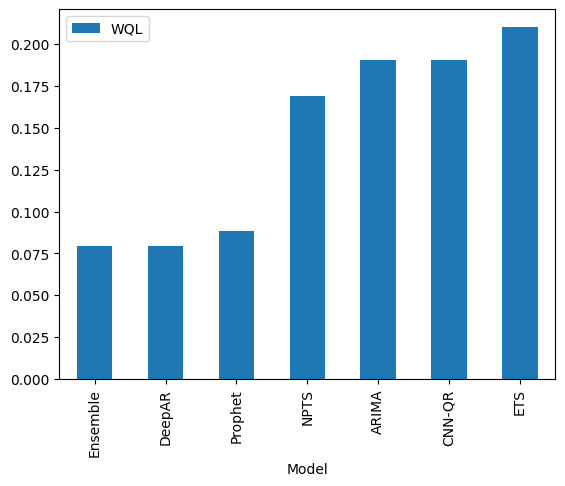

In [18]:
candidates_df[["WQL"]].plot(kind="bar");

In [19]:
from fev_helpers import cast_predictions
from predictions_helpers import drop_header_rows, cast_types, remove_duplicates


def sanitize_predictions(df: pd.DataFrame) -> pd.DataFrame:
    """Fixes issues than can arise from sagemaker parallel batch transform job"""
    df = drop_header_rows(df)
    df = cast_types(df)
    df = remove_duplicates(df)
    return df


sm_predictions_df = sanitize_predictions(forecasts_sagemaker.predictions_df)

# create fev evaluation summary for model leaderboard
sm_eval_summary = task.evaluation_summary(
    [cast_predictions(window, sm_predictions_df)],
    model_name="Sagemaker_AutoML",
    training_time_s=forecasts_sagemaker.train_time,
    inference_time_s=forecasts_sagemaker.predict_time,
)

/Users/khozzy/Projects/apytmiz/aptimyz-demand-forecast/scripts/fev_helpers.py:20: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



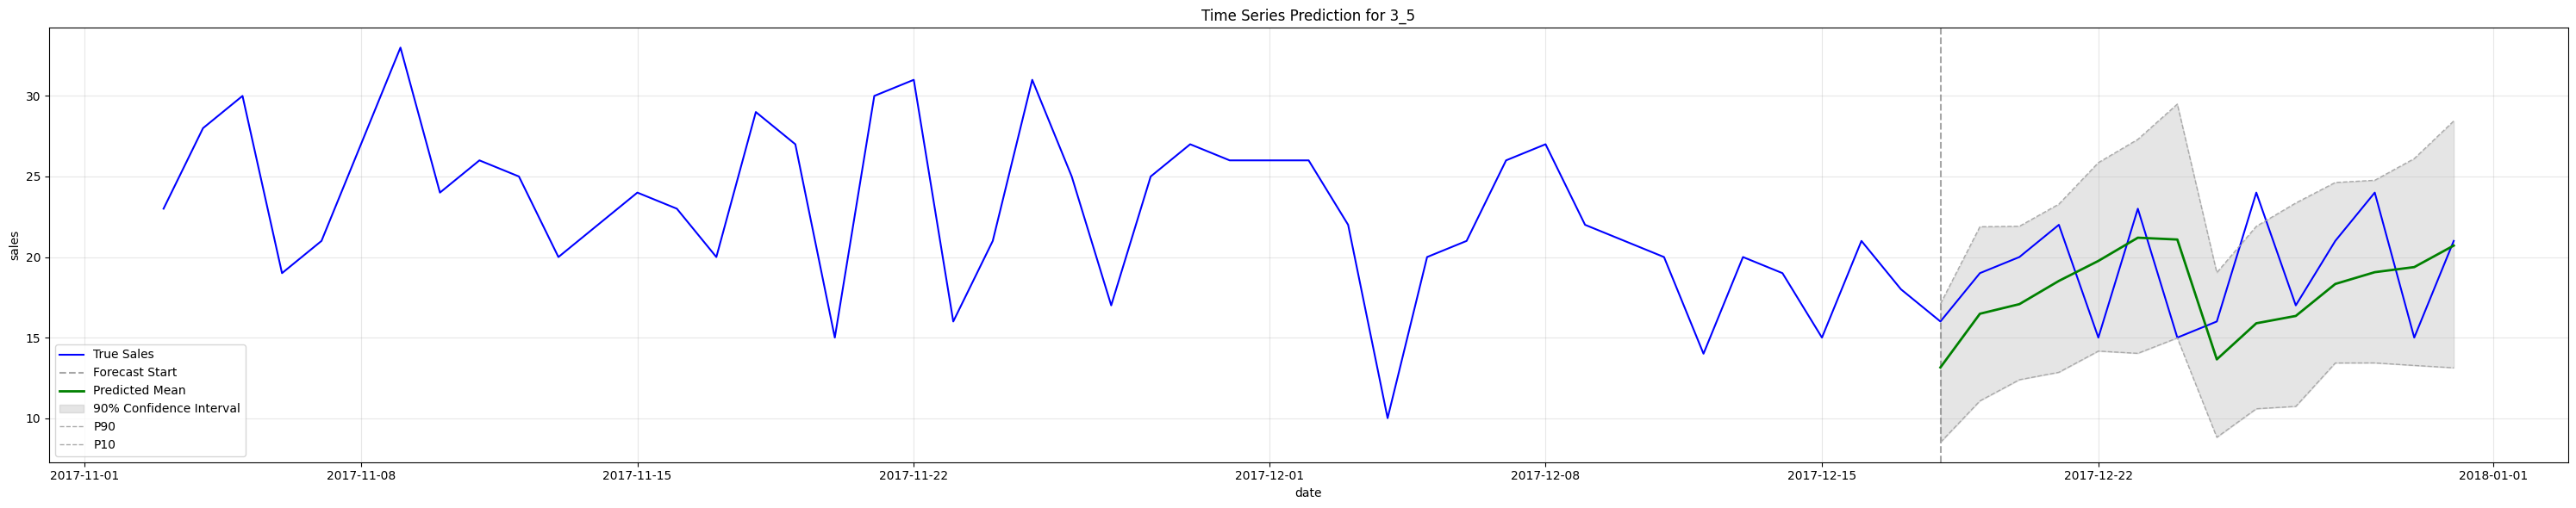

In [ ]:
# visualize predictions on a timeline
from plot_series_with_predictions import plot_series_with_predictions

# merge original training dataset with predictions (based on matching series id and date)
merged_df = pd.merge(df, sm_predictions_df, on=["series_id", "date"], how="left")

fig, ax = plt.subplots(figsize=(30, 6))
plot_series_with_predictions(
    merged_df, series_id="3_5", horizon=14, history_window=45, fig=fig, ax=ax
)
plt.show()


In [21]:
# sm_predictions_df
# train_df, _, _ = fev.convert_input_data(window, adapter="pandas")
# train_df

### Leaderboard

In [22]:
fev.leaderboard(
    [sm_eval_summary], baseline_model="Sagemaker_AutoML", metric_column="WQL"
)

/Users/khozzy/Projects/apytmiz/aptimyz-demand-forecast/.venv/lib/python3.12/site-packages/fev/analysis.py:498: RuntimeWarning:

Mean of empty slice



,skill_score,win_rate,median_training_time_s,median_inference_time_s,training_corpus_overlap,num_failures
model_name,,,,,,
Sagemaker_AutoML,0.0,NaN,1723.049839,422.804373,0.0,0


## Next Steps
- Plug-in Aptymiz real-world business dataset
- Evaluate Autogluon (Chronos?) framework
- Gluon Models https://ts.gluon.ai/stable/getting_started/models.html

## Evaluation Metrics

- Metrics supported by [SageMaker time series forecast](https://docs.aws.amazon.com/sagemaker/latest/dg/canvas-metrics.html#canvas-time-series-forecast-metrics) training are: WQL, WAPE, RMSE, MAPE, MASE.

